<a href="https://colab.research.google.com/github/ajaykumar057/stock_analysis/blob/main/stock_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install yfinance tensorflow scikit-learn matplotlib pandas


In [2]:
import os
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
params = {
    "ticker": "AAPL",        # <-- Change ticker here
    "start": "2018-01-01",
    "end": None,             # None = today
    "time_step": 60,
    "epochs": 12,
    "batch_size": 32,
    "train_split": 0.8,
    "val_split": 0.1,
    "price_col": "Close"
}

# if no end date, set to today + 1 (yfinance end exclusive)
if params["end"] is None:
    params["end"] = (pd.Timestamp.today() + timedelta(days=1)).strftime('%Y-%m-%d')

os.makedirs("outputs", exist_ok=True)


In [4]:
def download_stock(ticker, start, end):
    print(f"Downloading {ticker} from {start} to {end} ...")
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        raise ValueError("No data downloaded. Check ticker and dates.")
    return df

def prepare_series(df, price_col='Close'):
    if price_col not in df.columns:
        raise ValueError(f"Price column '{price_col}' not in data. Available: {df.columns.tolist()}")
    series = df[[price_col]].copy()
    series = series.fillna(method='ffill').dropna()
    return series

def create_dataset(values, time_step):
    X, y = [], []
    n = len(values)
    for i in range(n - time_step):
        X.append(values[i:(i + time_step), 0])
        y.append(values[i + time_step, 0])
    return np.array(X), np.array(y)

def build_lstm(time_step):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true))) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape}


/tmp/ipython-input-1217243882.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Downloaded rows: 1931
Samples -> total: 1871, train: 1496, test: 375


/tmp/ipython-input-1217243882.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='ffill').dropna()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0366
Epoch 1: val_loss improved from inf to 0.00108, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.0361 - val_loss: 0.0011
Epoch 2/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.1029e-04
Epoch 2: val_loss improved from 0.00108 to 0.00085, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.0988e-04 - val_loss: 8.4994e-04
Epoch 3/12
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.2790e-04
Epoch 3: val_loss improved from 0.00085 to 0.00076, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.2778e-04 - val_loss: 7.5758e-04
Epoch 4/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.7086e-04
Epoch 4: val_loss did not improve from 0.00076
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.6998e-04 - val_loss: 8.3388e-04
Epoch 5/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.1177e-04
Epoch 5: val_loss did not improve from 0.00076
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 5.1138e-04 - val_loss: 9.5063e-04
Epoch 6/12
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5668e-04
Epoch 6: val_loss improved from 0.00076 to 0.00074, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 5.5544e-04 - val_loss: 7.4422e-04
Epoch 7/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.9271e-04
Epoch 7: val_loss improved from 0.00074 to 0.00067, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 4.9258e-04 - val_loss: 6.7295e-04
Epoch 8/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.0578e-04
Epoch 8: val_loss did not improve from 0.00067
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 5.0541e-04 - val_loss: 0.0013
Epoch 9/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.8492e-04
Epoch 9: val_loss improved from 0.00067 to 0.00062, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.8085e-04 - val_loss: 6.2073e-04
Epoch 10/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.0650e-04
Epoch 10: val_loss did not improve from 0.00062
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.0597e-04 - val_loss: 6.3665e-04
Epoch 11/12
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.7802e-04
Epoch 11: val_loss improved from 0.00062 to 0.00058, saving model to outputs/model_AAPL.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.7815e-04 - val_loss: 5.8466e-04
Epoch 12/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.6142e-04
Epoch 12: val_loss did not improve from 0.00058
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 3.6171e-04 - val_loss: 0.0011
Restoring model weights from the end of the best epoch: 11.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
📊 Evaluation metrics: {'RMSE': np.float64(8.478068612596996), 'MAE': 6.649001121520996, 'MAPE%': np.float32(3.0628908)}
Saved predictions CSV: outputs/AAPL_predictions.csv


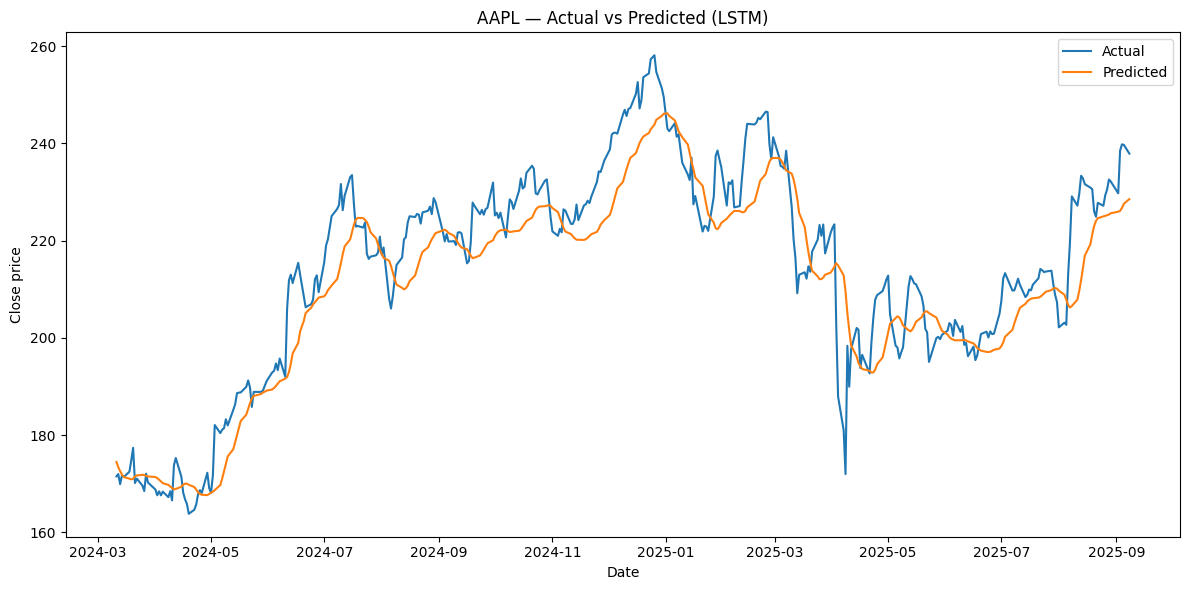

In [5]:
# 1) download
df = download_stock(params["ticker"], params["start"], params["end"])
print("Downloaded rows:", len(df))

# 2) prepare series
series = prepare_series(df, price_col=params["price_col"])
dates = series.index.to_list()
values = series.values.astype("float32")

# 3) scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 4) sequences
X, y = create_dataset(scaled, params["time_step"])
X = X.reshape((X.shape[0], X.shape[1], 1))
dates_y = dates[params["time_step"]:]

# 5) train/test split
split_idx = int(len(X) * params["train_split"])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = dates_y[split_idx:]

print(f"Samples -> total: {len(X)}, train: {len(X_train)}, test: {len(X_test)}")

# 6) build model
model = build_lstm(params["time_step"])
model.summary()

ckpt_path = os.path.join("outputs", f"model_{params['ticker']}.h5")
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
]

# 7) train
history = model.fit(
    X_train, y_train,
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    validation_split=params["val_split"],
    callbacks=callbacks,
    verbose=1
)

# 8) predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 9) metrics
metrics = evaluate_metrics(y_test_inv, y_pred)
print("📊 Evaluation metrics:", metrics)

# 10) save predictions
out_df = pd.DataFrame({
    "date": dates_test,
    "actual": y_test_inv,
    "predicted": y_pred
})
out_csv = os.path.join("outputs", f"{params['ticker']}_predictions.csv")
out_df.to_csv(out_csv, index=False)
print("Saved predictions CSV:", out_csv)

# 11) plot
plt.figure(figsize=(12,6))
plt.plot(out_df["date"], out_df["actual"], label="Actual")
plt.plot(out_df["date"], out_df["predicted"], label="Predicted")
plt.xlabel("Date")
plt.ylabel(f"{params['price_col']} price")
plt.title(f"{params['ticker']} — Actual vs Predicted (LSTM)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# =========================
# 📌 Cell 6: Next Day Forecast
# =========================
last_seq = scaled[-params["time_step"]:]
last_seq = np.reshape(last_seq, (1, params["time_step"], 1))

next_day_pred = model.predict(last_seq)
next_day_pred = scaler.inverse_transform(next_day_pred)

print(f"🔮 Predicted next day closing price for {params['ticker']}: ${next_day_pred[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🔮 Predicted next day closing price for AAPL: $229.44
